## 1. Seleccione un data-set para una aplicación clasificación de textos con más de dos clases proveniente de algún repositorio de datos, o de otra fuente

Para este caso, se opto por usar un repositorio de HuggingFace de emociones, conocido como GoEmotions simplificado traído de Hugging, orientado a una clasificación multiclase de texto (28 clases).


> Admiration [0], Amusement, Anger, Annoyance, Approval, Caring, Confusion, Curiosity, Desire, Disappointment, Disapproval, Disgust, Embarrassment, Excitement, Fear, Gratitude, Gried, Joy, Love, Nervousness, Optimism, Pride, Realization, Relief, Remorse, Sadness, Surprise, Neutral [27].
<!-- BRINDAR MÄS INFO -->

## Importando librerías

In [1]:
%pip install datasets==2.15.0 fsspec==2023.9.2 --quiet

Note: you may need to restart the kernel to use updated packages.


c:\Users\lfmb0\OneDrive\Escritorio\Especialización\segundoSemestre\ProcesamientoDatosDL\practicas\RNN_transformers\.venv\Scripts\python.exe: No module named pip


In [2]:
import sys

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

print("TensorFlow versión:", tf.__version__)

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow versión: 2.19.0


In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\lfmb0\OneDrive\Escritorio\Especialización\segundoSemestre\ProcesamientoDatosDL\practicas\RNN_transformers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga del dataset

In [4]:
ds = load_dataset("google-research-datasets/go_emotions", "simplified")

In [5]:
print(f"{ds}\n")
ds['train'][0]['labels']

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})



[27]

In [6]:
# El dataset contiene ejemplos multietiquetas más de dos labels en un solo text (ej. [5, 27]), se adapta a quedar en multiclase

# Multietiqueta -> Cada texto puede tener varias etiquetas simultáneamente
# Multiclase -> Cada texto tiene una sola etiqueta de entre varias posibles

def to_multiclass(example):
    example["label"] = example["labels"][0] if example["labels"] else 27  # 27 es "neutral"
    return example

ds = ds.map(to_multiclass)


In [7]:
ds['train'][0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [27],
 'id': 'eebbqej',
 'label': 27}

## Análisis del Dataset **GoEmotions**

In [8]:
# Para mejores consultas, usamos pandas para analizar en detalle el dataset de HuggingFace

df_train = pd.DataFrame(ds["train"])
df_test = pd.DataFrame(ds["test"])
df_val = pd.DataFrame(ds["validation"])

print(f"Vista de Dataset datos de entrenamiento\n{df_train.head()}\n{df_train.columns}")
print(f"\n{df_train.tail()}\n{df_train.columns}")

Vista de Dataset datos de entrenamiento
                                                text labels       id  label
0  My favourite food is anything I didn't have to...   [27]  eebbqej     27
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i     27
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj      2
3                        To make her feel threatened   [14]  ed7ypvh     14
4                             Dirty Southern Wankers    [3]  ed0bdzj      3
Index(['text', 'labels', 'id', 'label'], dtype='object')

                                                    text labels       id  \
43405  Added you mate well I’ve just got the bow and ...   [18]  edsb738   
43406  Always thought that was funny but is it a refe...    [6]  ee7fdou   
43407  What are you talking about? Anything bad that ...    [3]  efgbhks   
43408            More like a baptism, with sexy results!   [13]  ed1naf8   
43409                                    Enjoy the ride!   [17]  e

In [9]:
print(df_train.info())
print("_"*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43410 non-null  object
 1   labels  43410 non-null  object
 2   id      43410 non-null  object
 3   label   43410 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
None
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5427 entries, 0 to 5426
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5427 non-null   object
 1   labels  5427 non-null   object
 2   id      5427 non-null   object
 3   label   5427 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 169.7+ KB
None


In [10]:
print(df_train["label"].value_counts())

label
27    12823
0      4130
4      2596
1      2244
3      2138
15     2096
7      1772
10     1651
2      1547
18     1533
6      1268
9      1028
17     1013
20      974
5       966
25      874
26      751
13      700
22      698
11      580
8       543
14      510
24      404
12      248
19      105
23       96
16       65
21       57
Name: count, dtype: int64


## Construcción RNN

In [11]:
#@title Configuración variables
batch_size = 32
max_length = 600
max_tokens = 20000
num_classes = 28

In [12]:
def dataset_to_tf(ds_split):
    texts = [ex["text"] for ex in ds_split]
    labels = [ex["label"] for ex in ds_split]
    ds_tf = tf.data.Dataset.from_tensor_slices((texts, labels))
    return ds_tf

train_ds = dataset_to_tf(ds["train"])
val_ds = dataset_to_tf(ds["validation"])
test_ds = dataset_to_tf(ds["test"])

In [13]:
train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
#Visualicemos algunos de los Batchs generados
for example, label in train_ds.take(1):
  print('text: ', example.numpy()[:5])
  print('label: ', label.numpy()[:5])

text:  [b'Hopefully it helps you keep your emotions in check rather than letting others control you, [NAME].'
 b'Threaten to release....welp , nothing coming from this.'
 b'his talk show is pretty great'
 b"He has a humiliation kink. He's clearly not expressing it in a healthy way and should probably see a therapist and/or a professional [NAME]."
 b'Literally any type of pepper, Bell, chilli etc. Pain in the arse but I\xe2\x80\x99d rather limit my choices than have that allergic reaction again. ']
label:  [ 5 14  0 27 27]


In [15]:
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds.map(lambda x, y: x))

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
#Visualicemos algunos de los Batchs generados
for example2, label2 in int_train_ds.take(1):
  print('text: ', example2.numpy()[:3])
  print('label: ', label2.numpy()[:3])

text:  [[ 93  79  10 ...   0   0   0]
 [ 36 174  45 ...   0   0   0]
 [ 60 348   5 ...   0   0   0]]
label:  [15  0 27]


In [17]:
# Miremos algunas palabras del vocabulario con su respectivo índice
print("2 ---> ",text_vectorization.get_vocabulary()[2])
print(" 3 ---> ",text_vectorization.get_vocabulary()[3])
print('Vocabulary size: {}'.format(len(text_vectorization.get_vocabulary())))

2 --->  the
 3 --->  i
Vocabulary size: 20000


In [25]:
def visualizar_modelo_keras(model):
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.DiGraph()

    for layer in model.layers:
        layer_name = f"{layer.name}\n({layer.__class__.__name__})"

        # Obtener output_shape de forma segura
        try:
            output_shape = tuple(layer.output.shape)
        except:
            output_shape = "?"

        # Obtener número de parámetros
        try:
            param_count = layer.count_params()
        except:
            param_count = "?"

        # Etiqueta con más información
        label = f"{layer_name}\nOutput: {output_shape}\nParams: {param_count}"
        G.add_node(layer.name, label=label)

    # Conexiones entre capas
    for layer in model.layers:
        for node in layer._inbound_nodes:
            for tensor in node.input_tensors:
                try:
                    inbound_layer = tensor._keras_history[0]
                    G.add_edge(inbound_layer.name, layer.name)
                except Exception:
                    pass

    pos = nx.spring_layout(G, seed=11)
    labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=(10,6))
    nx.draw(G, pos, labels=labels, with_labels=True,
            node_color='lightblue', node_size=6000,
            font_size=8, edge_color='gray')
    plt.title("Visualización del Modelo RNN con Output y Parametros")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Modelo con codificación de embedding
```
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)
```

In [21]:
# Se hace un primer modelo usando como entrada codificación embedding
embedding_dim = 256

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim)(inputs)

x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 256)      │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,195,804 (19.82 MB)

 Trainable params: 5,195,804 (19.82 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\lfmb0\AppData\Local\Temp\ipykernel_21620\321455978.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


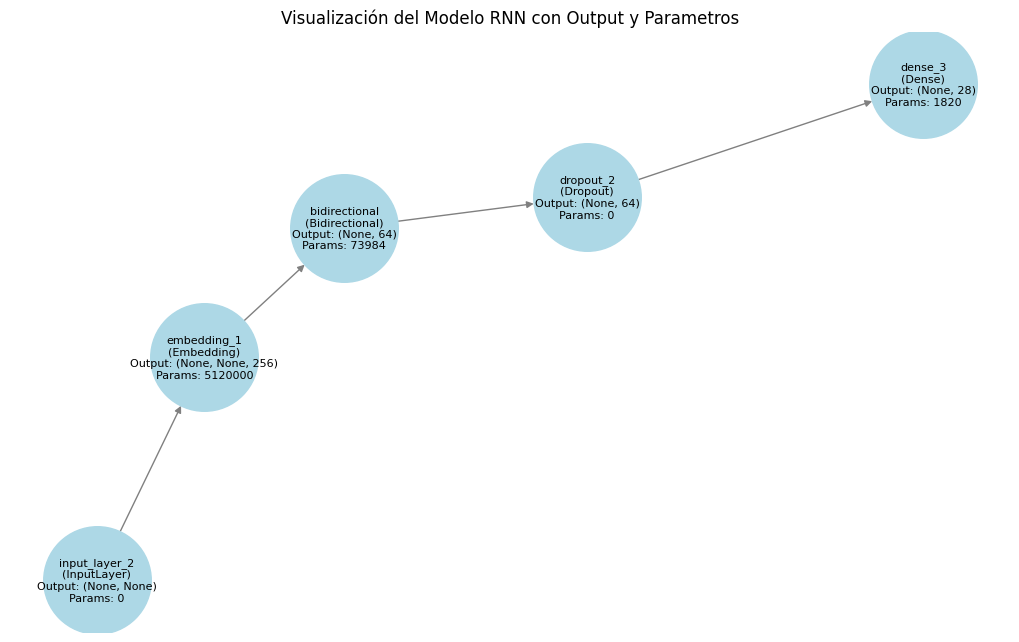

In [26]:
visualizar_modelo_keras(model)

In [85]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=7)
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 407s 298ms/step - accuracy: 0.3342 - loss: 2.6192 - val_accuracy: 0.4718 - val_loss: 2.0586
Epoch 2/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 405s 299ms/step - accuracy: 0.4702 - loss: 2.0496 - val_accuracy: 0.5079 - val_loss: 1.8499
Epoch 3/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 418s 308ms/step - accuracy: 0.5063 - loss: 1.8381 - val_accuracy: 0.5208 - val_loss: 1.7662
Epoch 4/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 414s 305ms/step - accuracy: 0.5331 - loss: 1.6906 - val_accuracy: 0.5299 - val_loss: 1.7442
Epoch 5/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 411s 303ms/step - accuracy: 0.5630 - loss: 1.5709 - val_accuracy: 0.5243 - val_loss: 1.7609
Epoch 6/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 407s 300ms/step - accuracy: 0.5933 - loss: 1.4669 - val_accuracy: 0.5275 - val_loss: 1.7783
Epoch 7/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 397s 293ms/step - accuracy: 0.6224 - loss: 1.3767 - val_accuracy: 0.5149 - val_loss: 1.8058
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.5046 - loss:

In [ ]:
model.save('../data/ModeloEmbeddingNoMask1.h5')

In [87]:
# Guardar vocabulario
vocab = text_vectorization.get_vocabulary()
with open("vocabulario.txt", "w", encoding="utf-8") as f:
    for palabra in vocab:
        f.write(palabra + "\n")

# Guardar etiquetas (emociones)
etiquetas = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
             'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
             'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
             'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
             'relief', 'remorse', 'sadness', 'surprise', 'neutral']

with open("etiquetas.txt", "w", encoding="utf-8") as f:
    for e in etiquetas:
        f.write(e + "\n")

In [88]:
# Prueba del modelo con un texto personalizado
Entrada = keras.Input(shape=(1,), dtype="string")
Entrada_procesada=text_vectorization(Entrada)
Salida=model(Entrada_procesada)
Inferencia=keras.Model(Entrada,Salida)

Texto_Ejemplo = tf.convert_to_tensor([["Happy birtday my dude"],])
# Ehhh, it's an opinion, it's not wrong or right, just highly unpopular and ill-informed.
# Yikes. I admire your patience
Prediccion=Inferencia(Texto_Ejemplo)
pred = Prediccion.numpy()[0]
print(pred)



[1.8703749e-02 5.9631052e-03 2.5423229e-04 8.7304210e-04 3.2983433e-02
 1.3268306e-02 1.4700643e-03 8.7984595e-03 4.8924116e-03 2.5456415e-03
 1.8304908e-03 1.5286104e-03 1.4469696e-03 1.2550919e-01 3.3673076e-03
 9.7880904e-03 1.0272766e-03 7.1982074e-01 5.5323364e-03 1.8348313e-03
 4.6171355e-03 7.9283380e-04 2.1673187e-03 2.2681658e-03 6.4113853e-04
 6.6250879e-03 3.9002250e-03 1.7549811e-02]


In [89]:
clase_pred = np.argmax(pred, axis=-1)
print(f"Etiqueta predicha: {clase_pred}")

# Etiquetas de GoEmotions para referencia
labels_names = ds["train"].features["labels"].feature.names
print(f"Clase predicha corresponde a: {labels_names[clase_pred].capitalize()}")

Etiqueta predicha: 17
Clase predicha corresponde a: Joy


In [90]:
# Ordenar
indices_ordenados = np.argsort(pred)[::-1]

print("Top 3 emociones predichas:")
for i in range(3):
    idx = indices_ordenados[i]
    print(f"{labels_names[idx].capitalize():<12} → {pred[idx]:.3f}")


Top 3 emociones predichas:
Joy          → 0.720
Excitement   → 0.126
Approval     → 0.033


## Modelo con enmascarado en capa embedding ya entrenada glove (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors)
```
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)
```

In [30]:
path_to_glove_file = "../data/embedding_glove6b/glove.6B.100d.txt"

embedding_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

In [31]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [33]:
# Inclusión del enmascarado en la capa de embedding
inputs2 = keras.Input(shape=(None,), dtype="int64")
embedded2 = embedding_layer(inputs2)
x = layers.Bidirectional(layers.LSTM(32))(embedded2)
x = layers.Dropout(0.5)(x)
outputs2 = layers.Dense(num_classes, activation="softmax")(x)
model2 = keras.Model(inputs2, outputs2)
model2.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 100) │  2,000,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     34,048 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 28)        │      1,820 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,035,868 (7.77 MB)

 Trainable params: 35,868 (140.11 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

C:\Users\lfmb0\AppData\Local\Temp\ipykernel_21620\321455978.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


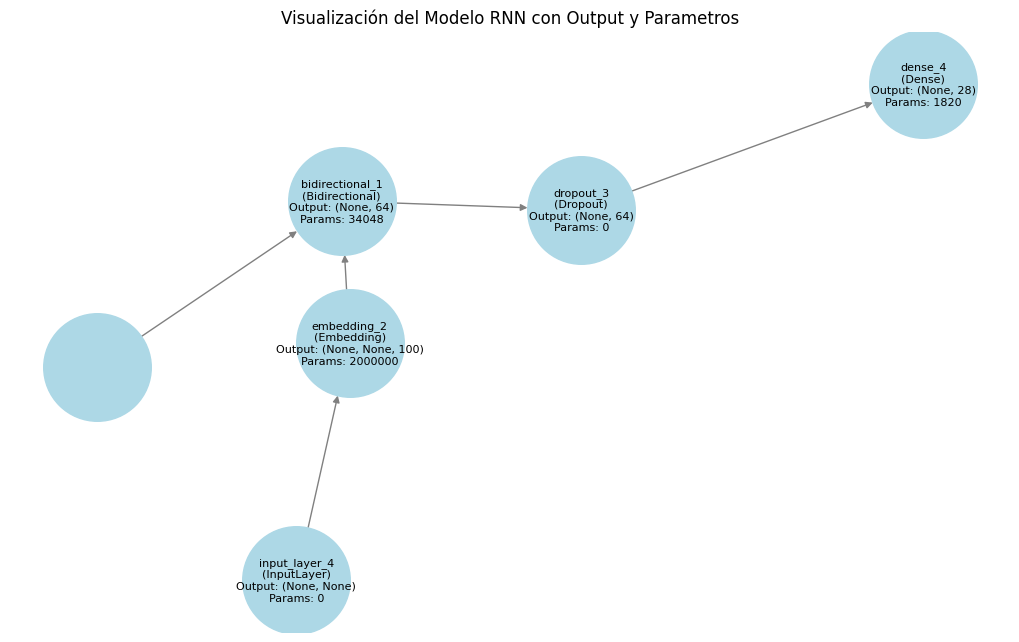

In [34]:
visualizar_modelo_keras(model2)

In [42]:
model2.fit(int_train_ds, validation_data=int_val_ds, epochs=7)
print(f"Test acc: {model2.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 298s 217ms/step - accuracy: 0.3246 - loss: 2.6333 - val_accuracy: 0.4270 - val_loss: 2.0976
Epoch 2/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 296s 218ms/step - accuracy: 0.4232 - loss: 2.1471 - val_accuracy: 0.4545 - val_loss: 1.9534
Epoch 3/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 299s 221ms/step - accuracy: 0.4468 - loss: 2.0244 - val_accuracy: 0.4790 - val_loss: 1.8725
Epoch 4/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 287s 212ms/step - accuracy: 0.4655 - loss: 1.9530 - val_accuracy: 0.4873 - val_loss: 1.8214
Epoch 5/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 272s 200ms/step - accuracy: 0.4739 - loss: 1.9075 - val_accuracy: 0.4932 - val_loss: 1.8008
Epoch 6/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 262s 193ms/step - accuracy: 0.4845 - loss: 1.8767 - val_accuracy: 0.5033 - val_loss: 1.7797
Epoch 7/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 276s 204ms/step - accuracy: 0.4866 - loss: 1.8602 - val_accuracy: 0.5044 - val_loss: 1.7614
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5003 - loss:

In [ ]:
model2.save('../data/ModeloEmbedingMask2.h5')

In [56]:
# Prueba del modelo con un texto personalizado
Entrada2 = keras.Input(shape=(1,), dtype="string")
Entrada_procesada2=text_vectorization(Entrada2)
Salida2=model2(Entrada_procesada2)
Inferencia2=keras.Model(Entrada2,Salida2)

Texto_Ejemplo2 = tf.convert_to_tensor([['What the fuck is that dude?'],])
pred2=Inferencia2(Texto_Ejemplo2)
print(pred2.numpy()[0])

[1.39091378e-02 1.05022518e-02 6.17608488e-01 1.37120858e-01
 5.83148282e-03 4.65083821e-03 8.51858314e-03 3.01097017e-02
 4.62837197e-04 3.00584384e-03 8.46316852e-03 1.72554683e-02
 2.21535168e-03 5.91039937e-03 3.60644888e-03 6.86860061e-04
 2.94006779e-04 1.12283765e-03 1.33126159e-03 5.44223352e-04
 7.71414139e-04 2.98864063e-04 1.79403473e-03 3.74102412e-04
 6.34576369e-04 1.01430202e-03 1.12601975e-02 1.10702455e-01]


In [57]:
# En este caso, sale directo en formato array, se pasa a entero para hacer función de los labels_names
clase_pred2 = np.argmax(pred2, axis=-1)[0]
clase_pred2 = int(clase_pred2)
print(f"Etiqueta predicha: {clase_pred2}")

# Etiquetas de GoEmotions para referencia
labels_names = ds["train"].features["labels"].feature.names
print(f"Clase predicha corresponde a: {labels_names[clase_pred2].capitalize()}")

Etiqueta predicha: 2
Clase predicha corresponde a: Anger


## Modelo BiGRU con embedding simple (Menos parametros y con 2 compuertas a diferencia del LSTM)
```
x = layers.Bidirectional(layers.GRU(32))(embedded5)
)
```

In [35]:
embedding_dim = 100

inputs3 = keras.Input(shape=(None,), dtype="int64")
embedded3 = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
)(inputs3)

x = layers.Bidirectional(layers.GRU(32))(embedded3)
x = layers.Dropout(0.5)(x)
outputs3 = layers.Dense(num_classes, activation="softmax")(x)

model3 = keras.Model(inputs3, outputs3)
model3.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])
model3.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 100)      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,027,548 (7.73 MB)

 Trainable params: 2,027,548 (7.73 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\lfmb0\AppData\Local\Temp\ipykernel_21620\321455978.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


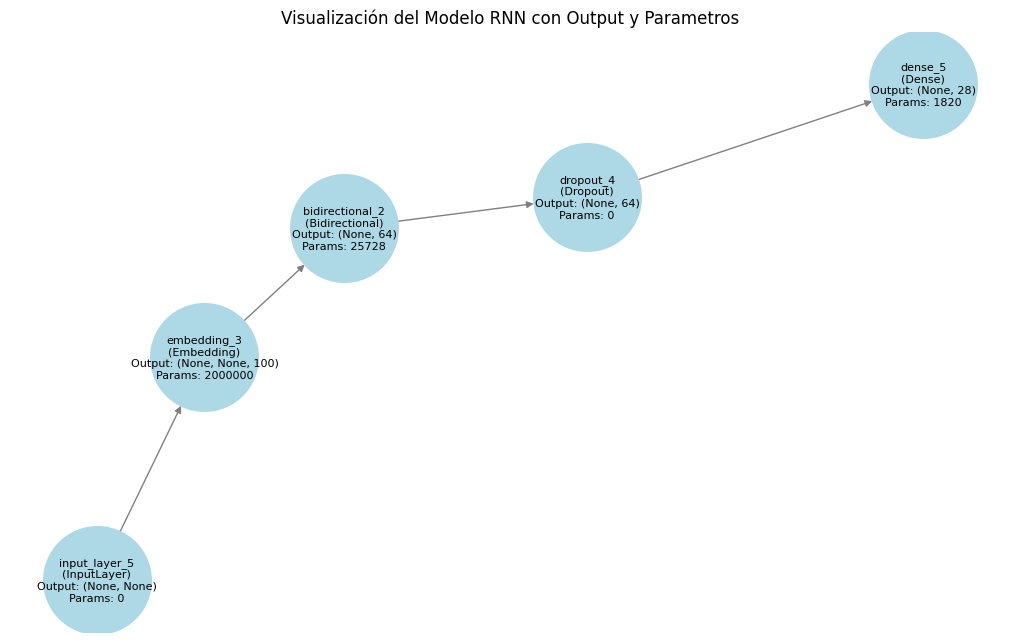

In [37]:
visualizar_modelo_keras(model3)

In [60]:
model3.fit(int_train_ds, validation_data=int_val_ds, epochs=7)
print(f"Test acc: {model3.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 325s 237ms/step - accuracy: 0.3305 - loss: 2.6380 - val_accuracy: 0.4655 - val_loss: 2.0718
Epoch 2/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 325s 240ms/step - accuracy: 0.4658 - loss: 2.0939 - val_accuracy: 0.5052 - val_loss: 1.8685
Epoch 3/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 318s 235ms/step - accuracy: 0.5025 - loss: 1.8953 - val_accuracy: 0.5251 - val_loss: 1.7932
Epoch 4/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 304s 224ms/step - accuracy: 0.5215 - loss: 1.7872 - val_accuracy: 0.5356 - val_loss: 1.7445
Epoch 5/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 300s 221ms/step - accuracy: 0.5363 - loss: 1.7080 - val_accuracy: 0.5330 - val_loss: 1.7354
Epoch 6/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 299s 220ms/step - accuracy: 0.5549 - loss: 1.6237 - val_accuracy: 0.5315 - val_loss: 1.7187
Epoch 7/7
1357/1357 ━━━━━━━━━━━━━━━━━━━━ 296s 218ms/step - accuracy: 0.5700 - loss: 1.5509 - val_accuracy: 0.5326 - val_loss: 1.7459
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5273 - loss:

In [ ]:
model3.save('../data/ModeloEmbedingGRU3.h5')

In [62]:
# Prueba del modelo con un texto personalizado
Entrada3 = keras.Input(shape=(1,), dtype="string")
Entrada_procesada3=text_vectorization(Entrada3)
Salida3=model3(Entrada_procesada3)
Inferencia3=keras.Model(Entrada3,Salida3)

Texto_Ejemplo3 = tf.convert_to_tensor([['What the fuck is that dude?'],])
pred3=Inferencia3(Texto_Ejemplo3)
print(pred3.numpy()[0])

[4.81916405e-03 8.11498705e-03 7.11669266e-01 1.44072622e-01
 9.43853799e-03 4.61336039e-03 6.61647506e-03 8.63808673e-03
 5.22898044e-05 1.72613328e-03 6.93490962e-03 1.42100705e-02
 2.16218294e-03 4.09969100e-04 3.06430925e-03 5.20145474e-03
 2.94369267e-04 4.62129159e-04 1.72461127e-03 6.75976393e-04
 7.22135301e-04 3.15433019e-04 6.03214430e-04 4.57913207e-04
 7.26815197e-04 2.40297988e-03 4.20850760e-04 5.94498217e-02]


In [63]:
# En este caso, sale directo en formato array, se pasa a entero para hacer función de los labels_names
clase_pred3 = np.argmax(pred3, axis=-1)[0]
clase_pred3 = int(clase_pred3)
print(f"Etiqueta predicha: {clase_pred3}")

# Etiquetas de GoEmotions para referencia
labels_names = ds["train"].features["labels"].feature.names
print(f"Clase predicha corresponde a: {labels_names[clase_pred3].capitalize()}")

Etiqueta predicha: 2
Clase predicha corresponde a: Anger


## Comparativa Modelos 
- BiLSTM con embedding simple (entrenable)
- BiLSTM con embedding preentrenado (fijo)
- BiGRU con embedding simple (entrenable)

In [103]:
test_loss1, test_acc1 = model.evaluate(int_test_ds)
print(f"Accuracy en test para el Modelo LSTM con un embedding simple: {test_acc1:.3f}\n")

test_loss2, test_acc2 = model2.evaluate(int_test_ds)
print(f"Accuracy en test para el Modelo LSTM con embedding preentrenado (glove_6b): {test_acc2:.3f}\n")

test_loss3, test_acc3 = model3.evaluate(int_test_ds)
print(f"Accuracy en test para el Modelo GRU con un embedding simple: {test_acc3:.3f}\n")

170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.5046 - loss: 1.8270
Accuracy en test para el Modelo LSTM con un embedding simple: 0.501

170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5003 - loss: 1.7953
Accuracy en test para el Modelo LSTM con embedding preentrenado (glove_6b): 0.492

170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.5273 - loss: 1.7860
Accuracy en test para el Modelo GRU con un embedding simple: 0.523



In [128]:
print(f"Modelo 1 - Cantidad de Parámetros: {model.count_params()}")
print(f"Modelo 2 - Cantidad de Parámetros: {model2.count_params()}")
print(f"Modelo 3 - Cantidad de Parámetros: {model3.count_params()}")

Modelo 1 - Cantidad de Parámetros: 5195804
Modelo 2 - Cantidad de Parámetros: 2035868
Modelo 3 - Cantidad de Parámetros: 2027548


In [127]:
for trainable_w in model.trainable_weights:
    print(trainable_w.name, trainable_w.shape)
    
print("-"*30)

for trainable_w in model2.trainable_weights:
    print(trainable_w.name, trainable_w.shape)

print("-"*30)

for trainable_w in model3.trainable_weights:
    print(trainable_w.name, trainable_w.shape)

embeddings (20000, 256)
kernel (256, 128)
recurrent_kernel (32, 128)
bias (128,)
kernel (256, 128)
recurrent_kernel (32, 128)
bias (128,)
kernel (64, 28)
bias (28,)
------------------------------
kernel (100, 128)
recurrent_kernel (32, 128)
bias (128,)
kernel (100, 128)
recurrent_kernel (32, 128)
bias (128,)
kernel (64, 28)
bias (28,)
------------------------------
embeddings (20000, 100)
kernel (100, 96)
recurrent_kernel (32, 96)
bias (2, 96)
kernel (100, 96)
recurrent_kernel (32, 96)
bias (2, 96)
kernel (64, 28)
bias (28,)


In [108]:
def metricas_modelos(modelo, dataset, labels_names, titulo="Modelo"):
    
    y_true, y_pred = [], []

    for x_batch, y_batch in dataset:
        preds = modelo.predict(x_batch, verbose=0)
        y_true.extend(y_batch.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # Reporte de clasificación
    print(f"\nReporte de clasificación para {titulo}:")
    print(classification_report(y_true, y_pred, target_names=labels_names, digits=3, zero_division=0))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_names, yticklabels=labels_names, cmap="Reds")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de confusión - {titulo}")
    plt.show()


Reporte de clasificación para LSTM Embedding construido:
                precision    recall  f1-score   support

    admiration      0.552     0.645     0.595       504
     amusement      0.729     0.770     0.749       252
         anger      0.421     0.416     0.418       197
     annoyance      0.242     0.154     0.188       286
      approval      0.312     0.236     0.269       318
        caring      0.284     0.202     0.236       114
     confusion      0.449     0.223     0.298       139
     curiosity      0.327     0.146     0.202       233
        desire      0.600     0.243     0.346        74
disappointment      0.289     0.102     0.151       127
   disapproval      0.221     0.200     0.210       220
       disgust      0.473     0.310     0.374        84
 embarrassment      0.000     0.000     0.000        30
    excitement      0.486     0.214     0.298        84
          fear      0.705     0.581     0.637        74
     gratitude      0.743     0.861     0.797

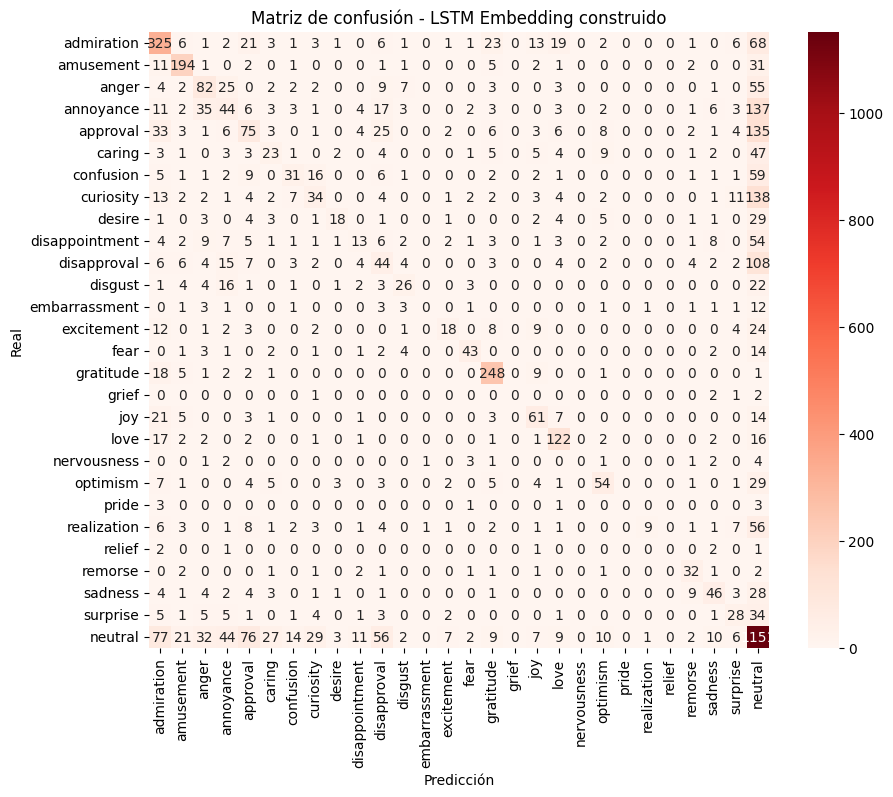

In [109]:
metricas_modelos(model, int_test_ds, labels_names, "LSTM Embedding construido")


Reporte de clasificación para LSTM Embedding glove6b:
                precision    recall  f1-score   support

    admiration      0.572     0.605     0.588       504
     amusement      0.757     0.706     0.731       252
         anger      0.403     0.274     0.326       197
     annoyance      0.270     0.035     0.062       286
      approval      0.383     0.057     0.099       318
        caring      0.312     0.044     0.077       114
     confusion      0.000     0.000     0.000       139
     curiosity      0.280     0.030     0.054       233
        desire      0.778     0.189     0.304        74
disappointment      0.250     0.024     0.043       127
   disapproval      0.143     0.005     0.009       220
       disgust      0.390     0.190     0.256        84
 embarrassment      0.000     0.000     0.000        30
    excitement      0.556     0.119     0.196        84
          fear      0.531     0.230     0.321        74
     gratitude      0.770     0.882     0.822   

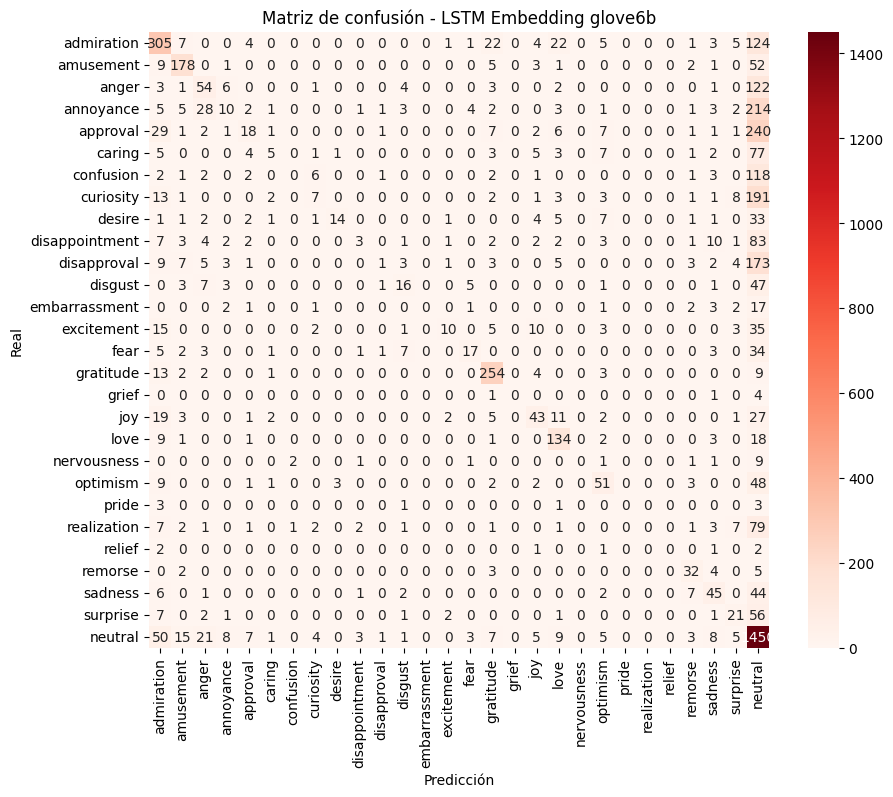

In [ ]:
metricas_modelos(model2, int_test_ds, labels_names, "LSTM Embedding glove6b")


Reporte de clasificación para GRU Embedding construido:
                precision    recall  f1-score   support

    admiration      0.629     0.595     0.612       504
     amusement      0.735     0.802     0.767       252
         anger      0.459     0.340     0.391       197
     annoyance      0.233     0.168     0.195       286
      approval      0.455     0.204     0.282       318
        caring      0.353     0.158     0.218       114
     confusion      0.420     0.151     0.222       139
     curiosity      0.432     0.206     0.279       233
        desire      0.607     0.230     0.333        74
disappointment      0.240     0.142     0.178       127
   disapproval      0.362     0.095     0.151       220
       disgust      0.500     0.274     0.354        84
 embarrassment      0.000     0.000     0.000        30
    excitement      0.714     0.238     0.357        84
          fear      0.613     0.662     0.636        74
     gratitude      0.802     0.872     0.835 

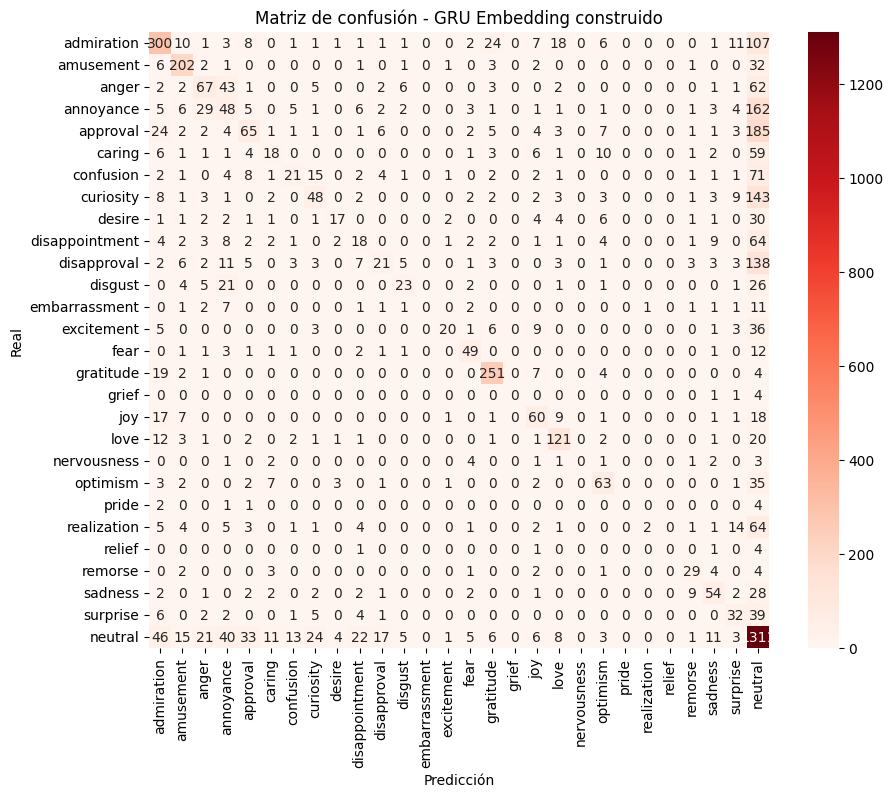

In [111]:
metricas_modelos(model3, int_test_ds, labels_names, "GRU Embedding construido")

## Modelo Transformers

In [38]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # dk
        self.dense_dim = dense_dim  # Nff
        self.num_heads = num_heads  #h
        # DK = (embed_dim/num_heads)
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=round(embed_dim/num_heads))

        self.layernorm_1 = layers.LayerNormalization()
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [39]:
vocab_size = 20000
embed_dim = 256
num_heads = 1
dense_dim = 512
num_classes = 28

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
modelTF = keras.Model(inputs, outputs)
modelTF.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
modelTF.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 256)      │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, None, 256)      │       527,104 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,654,300 (21.57 MB)

 Trainable params: 5,654,300 (21.57 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\lfmb0\AppData\Local\Temp\ipykernel_21620\321455978.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


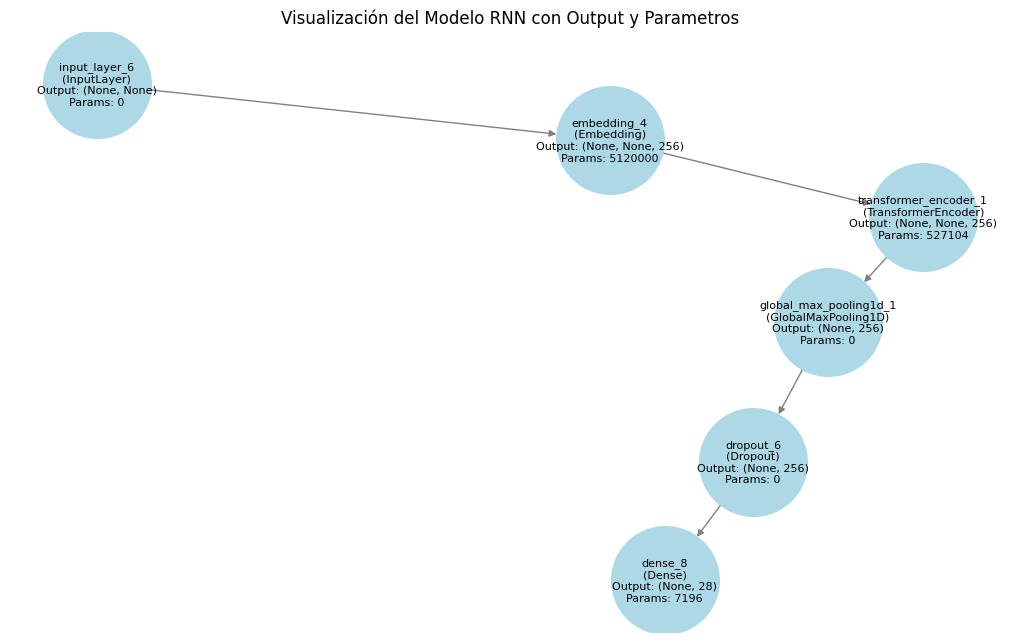

In [41]:
visualizar_modelo_keras(modelTF)

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
modelTF.fit(int_train_ds, validation_data=int_val_ds, epochs=1, callbacks=callbacks)
modelTF = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {modelTF.evaluate(int_test_ds)[1]:.3f}")

1357/1357 ━━━━━━━━━━━━━━━━━━━━ 1386s 1s/step - accuracy: 0.3145 - loss: 2.8405 - val_accuracy: 0.4993 - val_loss: 1.9037


c:\Users\lfmb0\OneDrive\Escritorio\Especialización\segundoSemestre\ProcesamientoDatosDL\practicas\RNN_transformers\.venv\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 47s 274ms/step - accuracy: 0.4938 - loss: 1.9300
Test acc: 0.487


In [43]:
modelTF.save('../data/ModeloTransformers1.h5')

In [45]:
Entrada = keras.Input(shape=(1,), dtype="string")
Entrada_procesada=text_vectorization(Entrada)
Salida=modelTF(Entrada_procesada)
Inferencia=keras.Model(Entrada,Salida)

Texto_Ejemplo = tf.convert_to_tensor([['Those watermelons are so expensive, we should go to another market'],])
predtf=Inferencia(Texto_Ejemplo)
print(predtf.numpy()[0])

[5.2108660e-02 9.1008088e-03 2.2681132e-02 3.5611730e-02 6.9086894e-02
 2.9452529e-02 1.6850183e-02 4.4747248e-02 1.0666309e-02 1.7167769e-02
 2.4377534e-02 1.3369672e-02 3.1559689e-03 1.6186411e-02 1.4456163e-02
 7.9065952e-03 4.9751130e-04 1.6243344e-02 1.2604274e-02 9.1331260e-04
 1.6251219e-02 8.6559972e-04 1.5925616e-02 8.5563021e-04 3.9170436e-03
 2.0071669e-02 9.1794934e-03 5.1574963e-01]


In [46]:
# En este caso, sale directo en formato array, se pasa a entero para hacer función de los labels_names
clase_predtf = np.argmax(predtf, axis=-1)[0]
clase_predtf = int(clase_predtf)
print(f"Etiqueta predicha: {clase_predtf}")

# Etiquetas de GoEmotions para referencia
labels_names = ds["train"].features["labels"].feature.names
print(f"Clase predicha corresponde a: {labels_names[clase_predtf].capitalize()}")

Etiqueta predicha: 27
Clase predicha corresponde a: Neutral
